# Settings

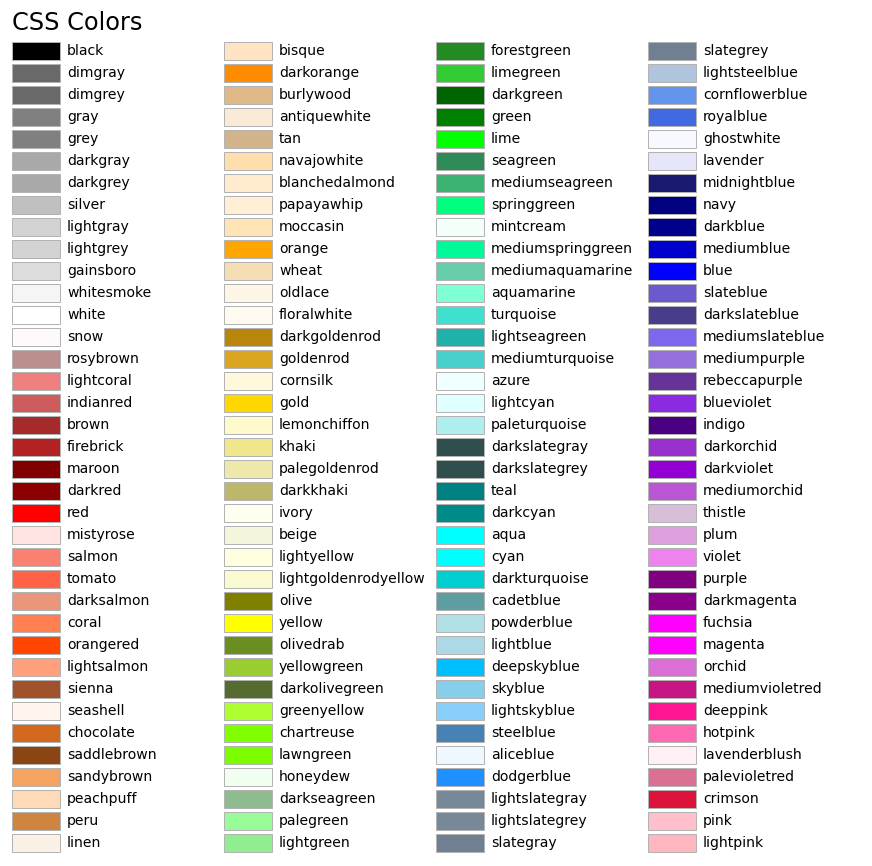

In [ ]:
# Подключение Гугл Диска
# Карты сохраняются в папку mars_maps на Гугл Диске
from google.colab import drive
drive.mount('/content/drive')
!mkdir /content/drive/MyDrive/mars_maps

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/content/drive/MyDrive/mars_maps’: File exists


In [ ]:
ITEMS = ['steel', 'titan', 'cards', 'leaves', 'water']

# Границы числа ресурсов на всём поле
ITEM_COUNT_BOUNDS = {'steel': (11, 14),
                  'titan': (4, 6),
                  'cards': (3, 8),
                  'leaves': (27, 40),
                  'water': (12, 12)}
# Границы числа кластеров с ресурсами
CLUSTER_COUNT_BOUNDS = {'steel': (3, 6),
                  'titan': (2, 4),
                  'cards': (2, 5),
                  'leaves': (1, 1),
                  'water': (2, 5)}

# Макс. кол-во ресурсов на одном гексе
MAX_HEX_ITEM = {'steel': 2,
                  'titan': 2,
                  'cards': 3,
                  'leaves': 2,
                  'water': 1}

# Цвета карты
hex_color = 'white'
water_color = 'steelblue'

# Цвета ресурсов
res_colors = {
    'leaves': 'lightgreen',
    'steel': 'saddlebrown',
    'titan': 'black',
    'cards': 'midnightblue'
}

# Относительные размеры "коробок" с ресурсами
x_box = {
    'leaves':[.3, -.3, -.3, .3, .3],
    'steel':[.3, -.3, -.3, .3, .3],
    'titan':[.3, -.3, -.3, .3, .3],
    'cards':[.2, -.2, -.2, .2, .2]
}
y_box = {
    'leaves':[.3, .3, -.3, -.3, .3],
    'steel':[.3, .3, -.3, -.3, .3],
    'titan':[.3, .3, -.3, -.3, .3],
    'cards':[.4, .4, -.4, -.4, .4]
}
text = {
    'leaves': '🍃',
    'steel': '🛠️',
    'titan': '⭐',
    'cards': '🌘'
}

# Map generator

In [ ]:
import random
import time
import matplotlib.pyplot as plt
import numpy as np

hex_steps = np.exp(np.arange(7) * np.pi / 3 * 1j)


class Hex():
    def __init__(self,  is_water=False, steel=0, titan=0, leaves=0, cards=0):
        self.count = {'steel' : steel,
                      'titan' : titan,
                      'leaves' : leaves,
                      'cards' : cards,
                      'water' : 0}
        self.style = {'steel' : steel,
                      'titan' : titan,
                      'leaves' : leaves,
                      'cards' : cards}
        if is_water:
            self.name = 'Wat'
        else:
            self.name = 'Hex'
    
    def __repr__(self):
        return self.name

    def add(self, name, count=1):
        if name == 'water':
            self.name = 'Wat'
        self.count[name] += count
    
    

class Mars():
    def __init__(self, size=5, seed=random.randint(1, 1e9), plot_size='small'):
        self.size = size
        self.plot_size = plot_size
        self.seed = seed
        random.seed(self.seed)
        self.board_size = list()
        self.board = list()
        for i in range(size * 2 - 1):
            self.board_size.append(size + min(i, size * 2 - 2 - i))
            self.board.append([Hex() for i in range(self.board_size[-1])])
        
        self.add_items()
    
    def table(self, save=False):
        "map.table() shows map in the output cell"
        if self.plot_size == 'small':
            plt.figure(figsize=(15, 15))
        if self.plot_size == 'big':
            plt.figure(figsize=(70, 70))
        ocean = list()
        hex = list()
        for j in range(len(self.board)):
            for i in range(self.board_size[j]):
                x = np.sqrt(3) * (i * 2 - min(j, self.size * 2 - 2 - j))
                y = -3 * j
                x_points = hex_steps.imag * 2 + x
                y_points = hex_steps.real * 2 + y
                color=[hex_color, water_color][self.board[j][i].name == 'Wat']
                plt.fill(x_points, y_points, color=color)
                plt.plot(x_points, y_points, color='black')

                self.plot_resourses(j, i, x, y)
        
        plt.axis('equal')
        plt.axis('off')
        if save: plt.savefig(f'/content/drive/MyDrive/mars_maps/{self.seed}.jpg')
        print(f'seed: {self.seed}')
        plt.show()
    
    def plot_resourses(self, j, i, x, y):
        res_arr = list()
        hex = self.board[j][i]
        for item in ITEMS:
            if item != 'water':
                res_arr += [item] * hex.count[item]
        if not res_arr:
            return None
        steps = np.exp(np.pi / len(res_arr) * np.arange(len(res_arr)) * 2j)
        x_points = steps.imag + x
        y_points = steps.real + y
        for i in range(len(res_arr)):
            item = res_arr[i]
            coords = [x_box[item] + x_points[i], y_box[item] + y_points[i]]
            plt.fill(*coords, res_colors[item])
            plt.plot(*coords, color='black')
    
    
    def add_items(self):
        """add_items() generates water, leaves, steel, titan and cards."""
        s = self.size
        for item in ITEMS:
            item_count = random.randint(*ITEM_COUNT_BOUNDS[item])
            cluster_count = random.randint(*CLUSTER_COUNT_BOUNDS[item])
            item_pos = list()
            while len(set(item_pos)) < cluster_count:
                pos = random.randint(0, 3 * s * (s - 1) + 1)
                i, j = self.to_coords(pos)
                if self.board[i][j].count[item] < MAX_HEX_ITEM[item]:
                    item_pos.append((i, j))
                    self.board[i][j].add(item)
            c = 300
            while len(item_pos) < item_count and c:
                c -= 1
                i, j = random.choice(item_pos)
                neighs = list()
                for a, b in self.neigh_list(i, j):
                    try:
                        if a > -1 and b > -1 and self.board[a][b].count[item] < MAX_HEX_ITEM[item]:
                            if item == 'titan' and self.board[a][b].count['steel']:
                                # breaking try using zero division
                                1/0
                            neighs.append((a, b))
                    except:
                        pass
                if neighs:
                    i, j = random.choice(neighs)
                    item_pos.append((i, j))
                    self.board[i][j].add(item)
    
    def neigh_list(self, i, j):
        """neigh_list(i, j) returns list of neighbors of the board[i][j] hex.
        """
        neighs = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        if i < self.size - 1:
            neighs += [(-1, -1), (1, 1)]
        if i == self.size - 1:
            neighs += [(-1, -1), (1, -1)]
        if i > self.size - 1:
            neighs = [(-1, 1), (1, -1)]
        return np.array(neighs) + [i, j]

    
    def to_coords(self, n):
        n -= 1
        i = 0
        for s in self.board_size:
            if n - s < 0:
                break
            n -= s
            i += 1
        return i, n


# Map creating cells

seed: 258000720


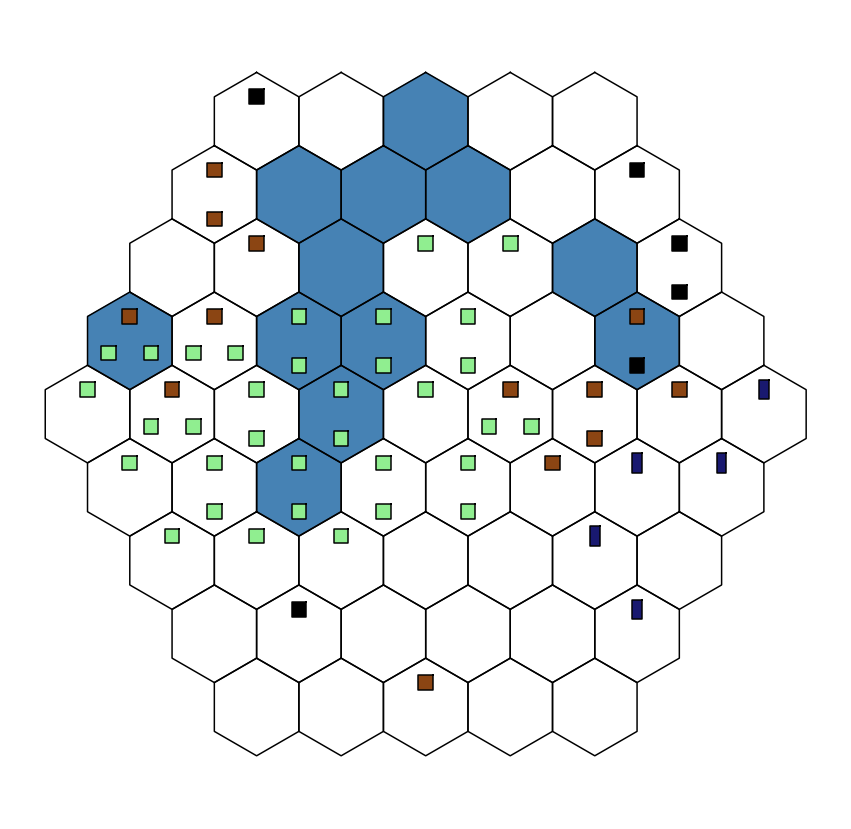

[Hex, Hex, Wat, Hex, Hex]
[Hex, Wat, Wat, Wat, Hex, Hex]
[Hex, Hex, Wat, Hex, Hex, Wat, Hex]
[Wat, Hex, Wat, Wat, Hex, Hex, Wat, Hex]
[Hex, Hex, Hex, Wat, Hex, Hex, Hex, Hex, Hex]
[Hex, Hex, Wat, Hex, Hex, Hex, Hex, Hex]
[Hex, Hex, Hex, Hex, Hex, Hex, Hex]
[Hex, Hex, Hex, Hex, Hex, Hex]
[Hex, Hex, Hex, Hex, Hex]


In [ ]:
# Посмотреть один пример
# Check one example
map = Mars()
map.table(save=False)
print(*map.board, sep='\n')

In [ ]:
# Сгенерировать кучу. Все файлы сохраняются на гугл диске, если вы его подключили

# СКОЛЬКО КАРТ ГЕНЕРИРОВАТЬ
# AMOUNT OF GENERATED MAPS
COUNT = 1000

time.clock()
for i in range(COUNT):
    Mars().table(save=True)
    print(f'{i + 1}/{COUNT} done.')
    print(f'About {(COUNT - i) * 1.125} seconds left.')
print(time.clock())